# **Data Visualization**

## Objectives

* The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

*  inputs/cherry_leaves_dataset/cherry-leaves/test
*  inputs/cherry_leaves_dataset/cherry-leaves/train
*  inputs/cherry_leaves_dataset/cherry-leaves/validation

## Outputs

* Answer buisness requirment 1
* Image shape embedding pickle file
* Show non infected leaves and health leaves



---

# Set Data directory

Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white") #set seaborn backround to white 
from matplotlib.image import imread # allows images to be read as arrays


We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

# Input Directories

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir
val_path = my_data_dir
test_path = my_data_dir

Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available, create a new version')
else:
    os.makedirs(name=file_path)

Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for images are',labels)

Label for images are ['test', 'train', 'validation']


---

# Data visualisation of image data

Compute average image size on train set

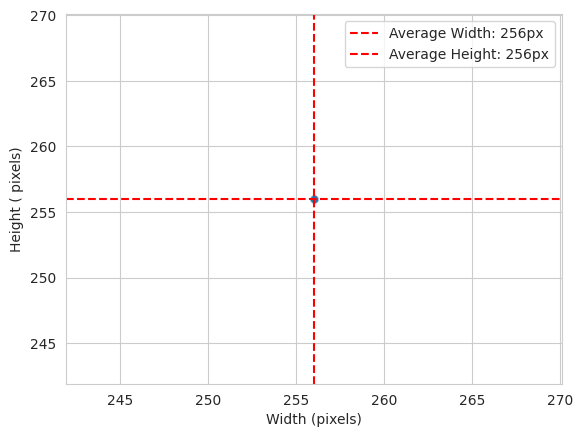

Width average: 256 
Height average: 256


In [8]:
data_dir = '/workspace/mildew-detector/inputs/cherry_leaves_dataset/cherry-leaves/train'
dim1, dim2 = [], []
train_path =  ['healthy', 'powdery_mildew']


for label in train_path:
    label_path = os.path.join(data_dir, label)
    for image_filename in os.listdir(label_path):
        img_path = os.path.join(label_path, image_filename)
        
        if os.path.isfile(img_path):
            img = imread(img_path)
            d1, d2, colors = img.shape
            dim1.append(d1) #height
            dim2.append(d2) #width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height ( pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim2_mean, color='r', linestyle='--', label=f'Average Width: {dim2_mean}px')
axes.axhline(y=dim1_mean, color='r', linestyle='--', label=f'Average Height: {dim1_mean}px')
axes.legend()
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

In [9]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

In [10]:
joblib.dump(value=image_shape ,
            filename=f'{file_path}/image_shape.pk1')

['outputs/v1/image_shape.pk1']

---

Average and variability of images per label

Load images in array

In [11]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(100,100), n_images_per_label=20):
    X, y = [], []
    labels = os.listdir(my_data_dir)
    print(f"Labels found: {labels}")
    for label in labels:
        label_path = os.path.join(my_data_dir, label)
        count = 0  # Initialize count for each label
        
        if os.path.isdir(label_path):  # Check if it's a directory
            for image_filename in os.listdir(label_path):
                if count >= n_images_per_label:  # Limit images per label
                    break
                img_path = os.path.join(label_path, image_filename)
                
                if os.path.isfile(img_path):
                    try:
                        img = image.load_img(img_path, target_size=new_size)
                        img_array = image.img_to_array(img)

                        if img_array.max() > 1:
                            img_array /= 255.0

                        X.append(img_array)
                        y.append(label)
                        count += 1
                    except Exception as e:
                        print(f"Error in loading image {img_path}: {e}")
        print(f"Loaded {count} images for label '{label}'")
    X = np.array(X)
    y = np.array(y)
    
    print(f"Total images loaded: {len(X)} with labels: {len(y)}")
    return X, y


In [12]:
my_data_dir = '/workspace/mildew-detector/inputs/cherry_leaves_dataset/cherry-leaves/train'
X,  y = load_image_as_array(my_data_dir)

print("X shape:", X.shape)
print("y shape:", y.shape)
if len(y) > 0:
    print("First label",y[0])
else:
    print("no images")


Labels found: ['healthy', 'powdery_mildew']
Loaded 20 images for label 'healthy'
Loaded 20 images for label 'powdery_mildew'
Total images loaded: 40 with labels: 40
X shape: (40, 100, 100, 3)
y shape: (40,)
First label healthy


**Images per label of mean and variable**

In [13]:
def plot_mean_varible_per_label(X, y , figsize=(12,5), save_image=False):
    for label_to_display in np.unique(y):
        sns.set_style("white")
        
        y_reshaped = y.reshape(-1,1,1)
        boolean_mask = np.any(y_reshaped == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]
        
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')
        
        if save_image and file_path:
            os.makedirs(file_path, exist_ok=True)
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight',dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")
        

==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


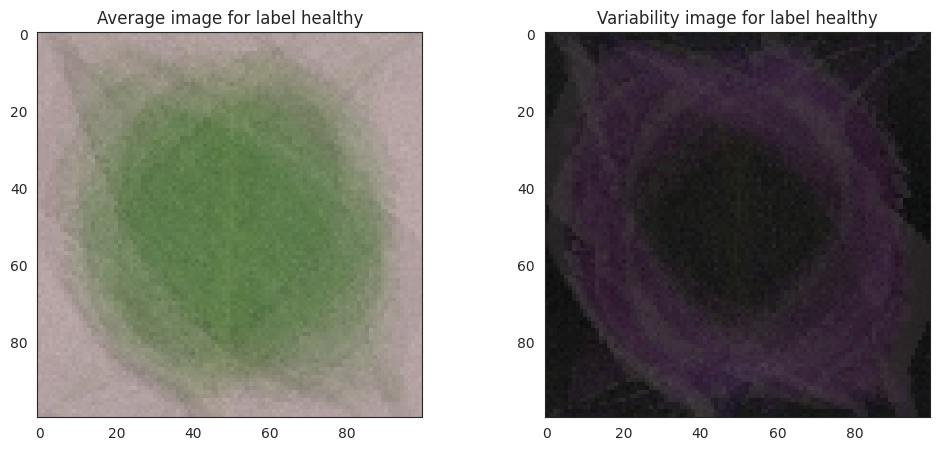

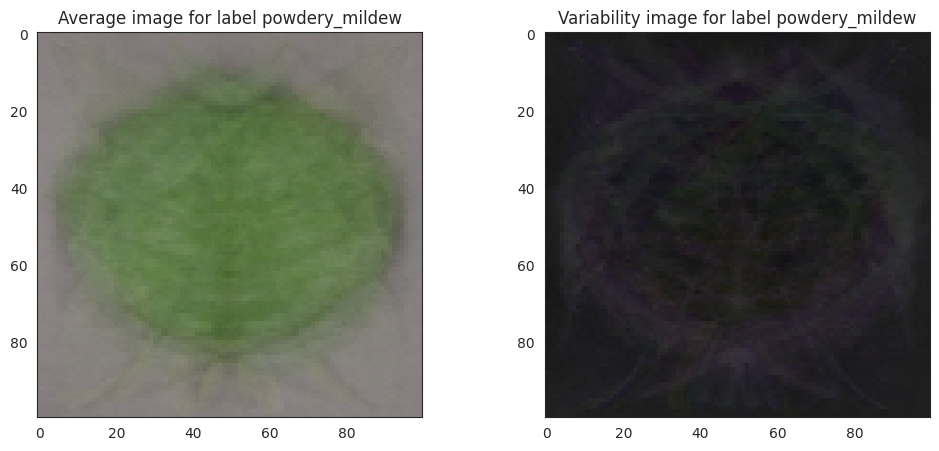

In [14]:
plot_mean_varible_per_label(X=X, y=y, figsize=(12, 5), save_image=True)

---

## **Difference between average mildew leaf and non mildew coverd leaf**


Mean of powdery_mildew: 0.43620941042900085, Std Dev: 0.07933160662651062
Mean of healthy: 0.5233932733535767, Std Dev: 0.11553984880447388


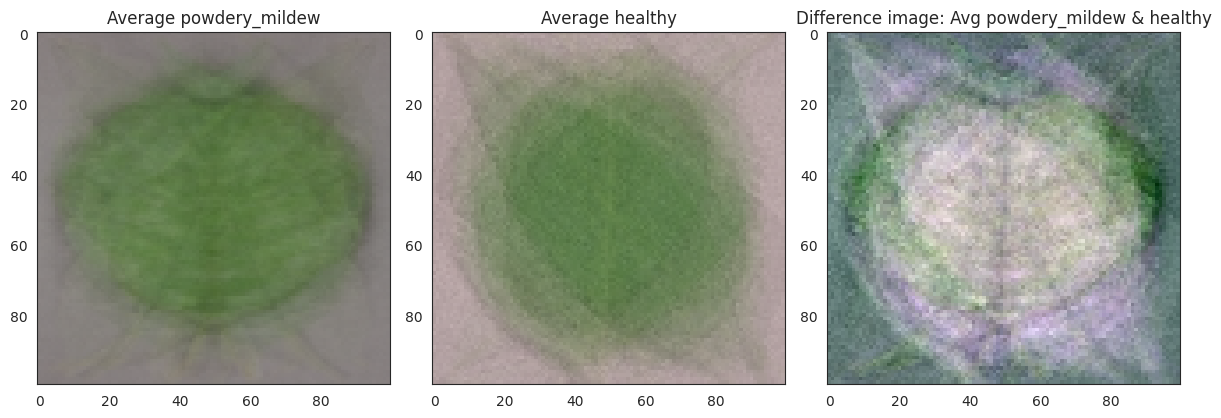

In [25]:
def subset_image_label(X, y, label_to_display):
    y_reshaped = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y_reshaped == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False, file_path=None):
    sns.set_style("white")
    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} is not in {np.unique(y)}")
        return
    
    # Calculate mean for label_1
    images_label1 = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label1, axis=0)
    
    # Calculate mean for label_2
    images_label2 = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label2, axis=0)
    
    # Print the means and std devs for diagnostic purposes
    print(f"Mean of {label_1}: {label1_avg.mean()}, Std Dev: {label1_avg.std()}")
    print(f"Mean of {label_2}: {label2_avg.mean()}, Std Dev: {label2_avg.std()}")
    
    # Calculate the difference
    difference_mean = label1_avg - label2_avg

    # Normalize difference_mean for visualization between [0, 1]
    diff_min, diff_max = difference_mean.min(), difference_mean.max()
    difference_normalized = (difference_mean - diff_min) / (diff_max - diff_min)

    # Plot the images
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    
    im = axes[2].imshow(difference_normalized, cmap='RdBu')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    
    # Add colorbar for the difference plot
    #fig.colorbar(im, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
    
    # Save or show the figure
    if save_image and file_path:
        os.makedirs(file_path, exist_ok=True)
        plt.savefig(f"{file_path}/avg_diff_{label_1}_vs_{label_2}.png", bbox_inches='tight', dpi=150)
    
    plt.tight_layout()
    plt.show()

# Example usage
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(12, 10),
                                        save_image=True,
                                        file_path='/workspace/mildew-detector/outputs')

# Image montage

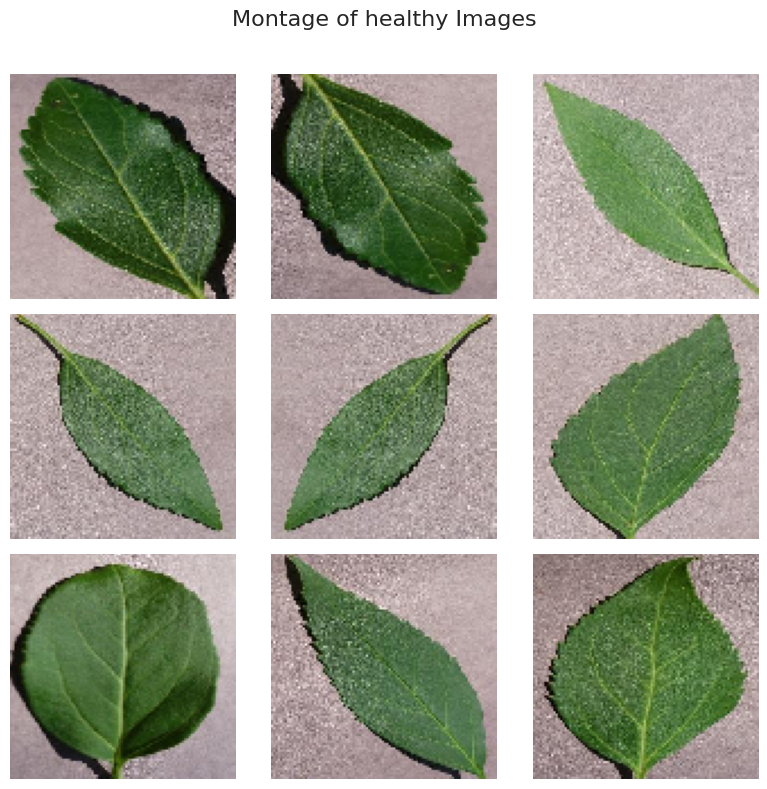

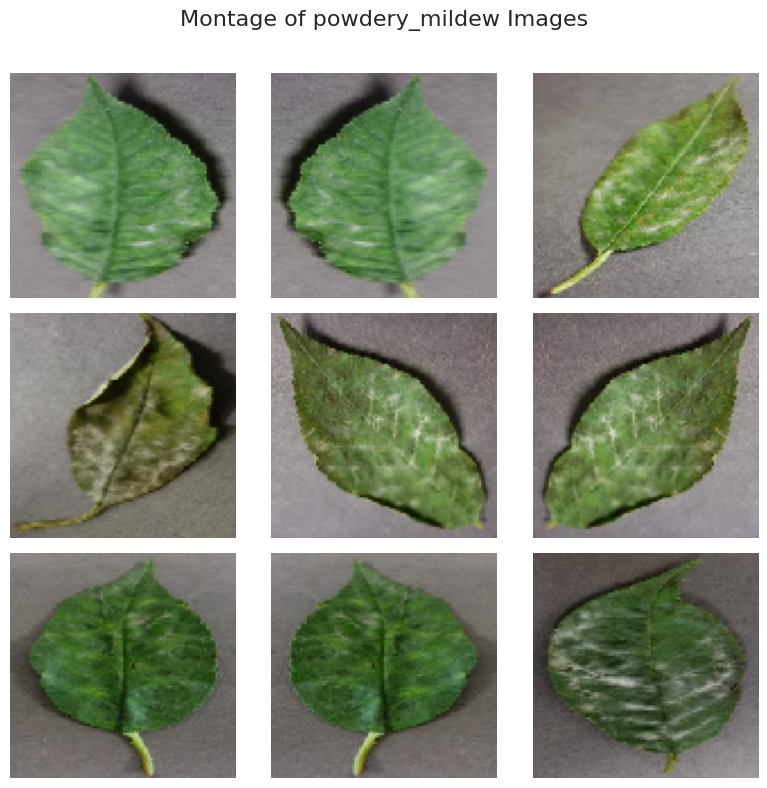

In [32]:
def image_montage(X, y, label, grid_size=(5, 5), figsize=(10, 10)):
    images_label = X[y == label]
    
    num_images = min(len(images_label), grid_size[0] * grid_size[1])
    images_label = images_label[:num_images]
    
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    axes = axes.flatten()
    
    for i in range(num_images):
        axes[i].imshow(images_label[i],cmap='gray')
        axes[i].axis('off')
        
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
        
    fig.suptitle(f"Montage of {label} Images", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()

# Example usage for creating montages
image_montage(X, y, label='healthy', grid_size=(3, 3), figsize=(8, 8))
image_montage(X, y, label='powdery_mildew', grid_size=(3, 3), figsize=(8, 8))   